In [1]:
from collections import Counter
from scipy.sparse import csr_matrix
from collections import defaultdict
from sklearn.cluster import KMeans
from numpy import *
%matplotlib inline
import matplotlib.pyplot as plt

def build_matrix_1(docs, labels):
    distinctWordsAndIndex = {}
    indexIter = 0
    nnz = 0
#     print(docs[0], labels)
    
    for idx, doc in enumerate(docs):
        frequency = doc.split()
        while frequency:
            term, freq, *frequency = frequency
            if term not in labels:
                continue
            
            nnz += 1
            if term not in distinctWordsAndIndex:
                distinctWordsAndIndex[term] = indexIter
                indexIter += 1    
                
    nrows = len(docs)
    ncols = len(distinctWordsAndIndex)
    
    ind = np.zeros(nnz, dtype=int)
    val = np.zeros(nnz, dtype=int)
    ptr = np.zeros(nrows+1, dtype=int)

    i = 0
    j = 0
    for idx, doc in enumerate(docs):
        ptr[j] = i
        j += 1
        frequency = doc.split()
        while frequency:
            term, freq, *frequency = frequency
            if term not in labels:
                continue
            ind[i] = distinctWordsAndIndex[term]
            val[i] = int(freq)
            i += 1
    ptr[j] = i

    mat = csr_matrix((val, ind, ptr), shape=(nrows, ncols), dtype=np.double)
    mat.sort_indices()
    
    return mat

In [2]:
#pre-processing
#Filter labels with length <= 3 and is present in stop words collection

import nltk
from nltk.corpus import stopwords

def getValidWords():
    stop_words = stopwords.words('english')
    with open("train.clabel", "r", encoding="utf8") as fh:
        labels = {}
#         print(len(fh.readlines()))
        for idx, word in enumerate(fh.readlines()):
            if len(word.rstrip()) < 4 or word.rstrip() in stop_words:
                continue
            labels[str(idx+1)] = word.rstrip()
    return labels
    # print(labels)

In [3]:
def BisectingKMeans(mat4, k_start, k_end, step):
    kValues = list()
    scores = list()
    
    for k in range(k_start, k_end+1, step):
        print('--------------------------------------------')
        X = mat4
        k_list = [] 
        sse_list = [] 
        total_SSE = 0
        current_clusters = 1

        clusterMap = {}
        for idx,row in enumerate(X):
            clusterMap[idx] = idx
        finalClusterLabels = {}

        while current_clusters != k:
            kmeans = KMeans(n_clusters=2, n_init=50).fit(X)
            cluster_centers = kmeans.cluster_centers_
            sse = [0]*2
            for point, label in zip(X, kmeans.labels_):
                sse[label] += np.square(point-cluster_centers[label]).sum()
            chosen_cluster = np.argmax(sse, axis=0)
            total_SSE += sse[np.argmin(sse, axis=0)]
            chosen_cluster_data = X[kmeans.labels_ == chosen_cluster]
            newClusterMap = {}
            clusterIter = 0
            #to keep track of the index of the clusters
            for idx, x in enumerate(kmeans.labels_):
                if(x != chosen_cluster):
                    finalClusterLabels[clusterMap[idx]] = current_clusters
                elif current_clusters + 1 == k:
                    finalClusterLabels[clusterMap[idx]] = current_clusters + 1
                else:
                    newClusterMap[clusterIter] = clusterMap[idx]
                    clusterIter += 1 
            clusterMap = newClusterMap
            current_clusters += 1
            assigned_cluster_data = X[kmeans.labels_ != chosen_cluster]
            X = chosen_cluster_data
        k_list.append(k)
        sse_list.append(kmeans.inertia_ )
        print_internal_metrics(mat4, finalClusterLabels)
        print('--------------------------------------------')
        
        labels = [finalClusterLabels[key] for key in sorted(finalClusterLabels.keys())]
        chscore = metrics.calinski_harabasz_score(mat4, labels)
        print(chscore)
        kValues.append(k)
        scores.append(chscore)
        
    import matplotlib.pyplot as plt

    plt.plot(kValues, scores)
    plt.xticks(kValues, kValues)
    plt.xlabel('No. of Clusters (k)')
    plt.ylabel('Calinski Harabaz Score')
    plt.title('CH vs k score')

    plt.savefig('plot.png')
    plt.show()
    
    return finalClusterLabels

In [4]:
#Internal Metrics
from sklearn import metrics

def print_internal_metrics(mat, labels_dict):
    labels = [labels_dict[key] for key in sorted(labels_dict.keys())]
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    print('K: %d' % n_clusters_)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(mat, labels))
    print("Calinski Harabasz Score: %0.3f" % metrics.calinski_harabasz_score(mat, labels))

(8580, 26237)
Shape before SVD (8580, 26237)
Start Time = 23:35:23
SVD number of concepts =  100
Variance ratio sum 0.25336556424333256
--------------------------------------------
K: 3
Silhouette Coefficient: 0.064
Calinski Harabasz Score: 373.874
--------------------------------------------
373.8744452166851
--------------------------------------------
K: 5
Silhouette Coefficient: 0.073
Calinski Harabasz Score: 358.566
--------------------------------------------
358.5663233710712
--------------------------------------------
K: 7
Silhouette Coefficient: 0.021
Calinski Harabasz Score: 290.219
--------------------------------------------
290.2193981450051
--------------------------------------------
K: 9
Silhouette Coefficient: 0.004
Calinski Harabasz Score: 244.866
--------------------------------------------
244.8657676519786
--------------------------------------------
K: 11
Silhouette Coefficient: 0.002
Calinski Harabasz Score: 213.935
--------------------------------------------
2

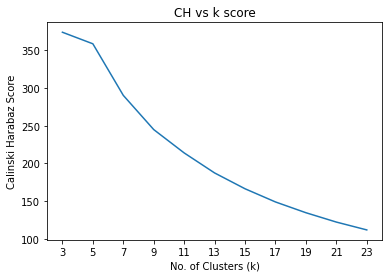

End Time = 23:54:39


In [5]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer 
from datetime import datetime

#Read the file
with open("train.dat", "r", encoding="utf8") as fh:
    rows = fh.readlines()
    
#Select valid words
valid_words = getValidWords()

#build csr matrix from valid words only
mat1 = build_matrix_1(rows, valid_words)
print(mat1.shape)

# TF-IDF transform to normalise the matrix
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tf_idf_vector=tfidf_transformer.fit(mat1).transform(mat1)

#print CST information
print('Shape before SVD', tf_idf_vector.shape)

print("Start Time =", datetime.now().strftime("%H:%M:%S"))

components = 100
while components < 101:
    print('============================================')
    print('SVD number of concepts = ', components)
    tsvd = TruncatedSVD(n_components=components)
    mat4 = tsvd.fit(tf_idf_vector).transform(tf_idf_vector)
    print('Variance ratio sum', tsvd.explained_variance_ratio_.sum())
    finalClusterLabels = BisectingKMeans(mat4, 3, 23, 2)
    components += 50
    print('============================================')
    
print("End Time =", datetime.now().strftime("%H:%M:%S"))

In [ ]:
# Plot k vs SSE graph for k-means
# components = 200
# while components < 501:
#     print('concepts', components)
#     wcss = []
#     for i in range(2,23,2):
#         kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
#         kmeans.fit(tf_idf_vector)
#         wcss.append(kmeans.inertia_)
#         print('k', i)
#     plt.plot(range(2,23,2),wcss)
#     plt.title('The Elbow Method')
#     plt.xlabel('Number of clusters')
#     plt.ylabel('WCSS')
#     plt.savefig('elbow.png')
#     plt.show()
#     components += 50

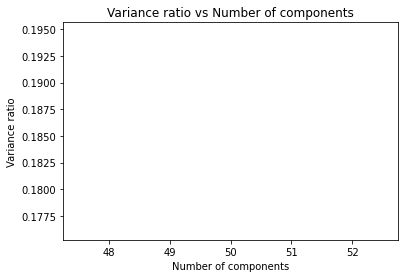

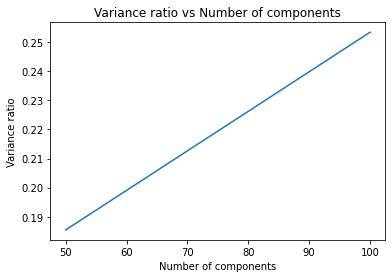

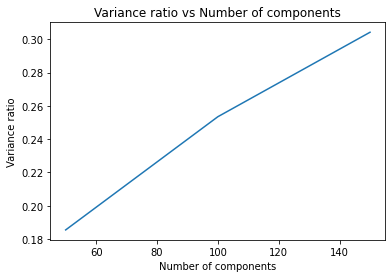

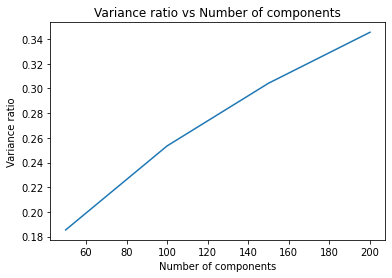

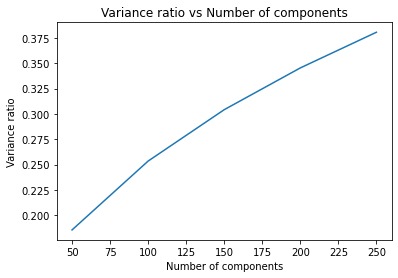

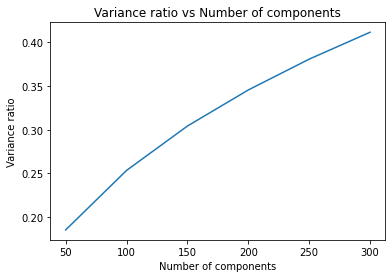

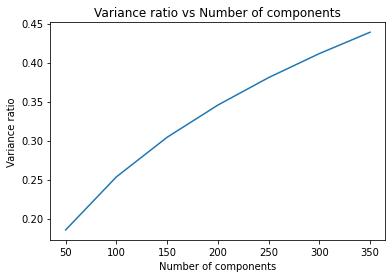

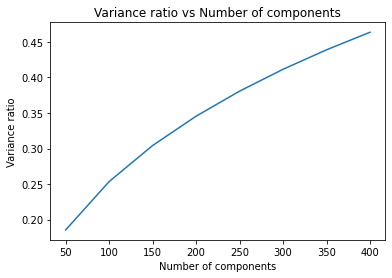

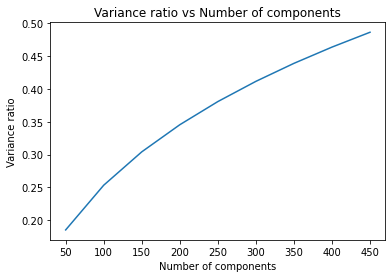

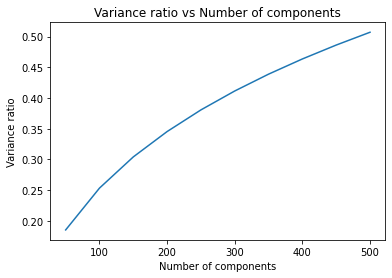

In [6]:
#Plot components vs Variance ratio for SVD
components = 50
wcss = []
num = [] 
while components < 501:
    
    tsvd = TruncatedSVD(n_components=components)
    mat4 = tsvd.fit(tf_idf_vector).transform(tf_idf_vector)
    wcss.append(tsvd.explained_variance_ratio_.sum())
    num.append(components)
    components += 50
    
plt.plot(num, wcss)
plt.title('Variance ratio vs Number of components')
plt.xlabel('Number of components')
plt.ylabel('Variance ratio')
plt.savefig('variance.png')
plt.show()

In [7]:
#write the cluster info to output file
labels = [finalClusterLabels[key] for key in sorted(finalClusterLabels.keys())]
with open("output.dat", "w", encoding="utf8") as file:
     for item in labels:
        file.write("%s\n" % str(item))

In [8]:
#print the number of elements in each cluster
count_labels = {}
for label in labels:
    
    if label not in count_labels:
        count_labels[label] = 1
    else:
        count_labels[label] = int(count_labels[label]) + 1
print(count_labels)

{1: 2879, 16: 292, 23: 358, 15: 287, 11: 165, 21: 126, 5: 1095, 12: 42, 18: 78, 20: 49, 14: 48, 19: 20, 13: 21, 17: 11, 6: 625, 4: 605, 3: 650, 2: 748, 7: 293, 8: 42, 22: 47, 10: 63, 9: 36}
